# FashionMNIST Tiny VGG CNN Solution

In [3]:
from rich.traceback import install
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x1078f3070>>

In [4]:
import torch

In [66]:
device =  "cpu"
device

'cpu'

## 0. Import all essentials

In [67]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt 

# Import numpy
import numpy as np 

# import pandas
import pandas as pd

import tqdm

print(f"PyTorch Version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch Version: 2.5.1
torchvision version: 0.20.1


In [68]:
import os
print(os.listdir())


['helper_functions.py', '__pycache__', '.ipynb_checkpoints', '.git', 'data', 'FashionMNIST_model.ipynb']


In [69]:
from helper_functions import *


## 1. Getting a dataset

PyTorch has a bunch of common computer vision datasets stored in `torchvision.datasets`.

Including FashionMNIST in `torchvision.datasets.FashionMNIST()`.

To download it, we provide the following parameters:

* `root: str` - which folder do you want to download the data to?
* `train: Bool` - do you want the training or test split?
* `download: Bool` - should the data be downloaded?
* `transform: torchvision.transforms` - what transformations would you like to do on the data?
* `target_transform` - you can transform the targets (labels) if you like too.


In [70]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # Where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well 
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [71]:
# Let's check sample
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [72]:
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [73]:
img.shape

torch.Size([1, 28, 28])

In [11]:
print(f"image shape: {img.shape} -> [colour_channels,height,width]")

image shape: torch.Size([1, 28, 28]) -> [colour_channels,height,width]


In [74]:
len(train_data), len(test_data)

(60000, 10000)

In [75]:
# Set classes
class_names = train_data.classes
class_names, len(class_names)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

## 1.2 Visualizing our data 

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

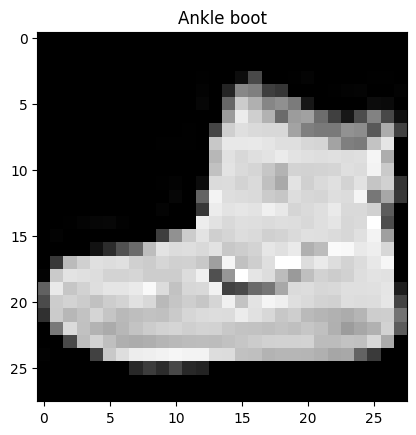

In [76]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

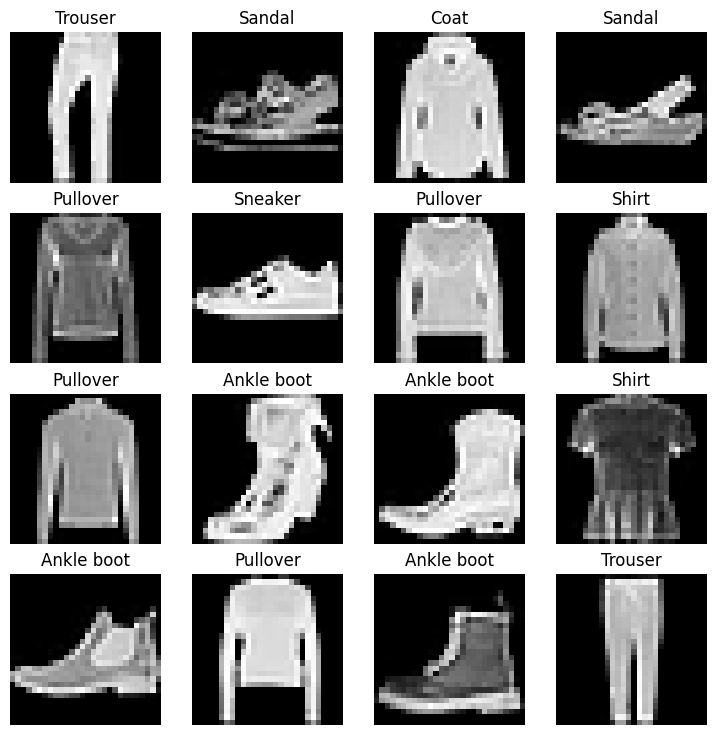

In [77]:
# Plot more images
plt.figure(figsize=(9,9))
nrows, ncols = 4,4
for i in range(1,nrows*ncols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    plt.subplot(nrows, ncols, i)
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader
Now we've got a dataset ready to go.

The next step is to prepare it with a `torch.utils.data.DataLoader` or `DataLoader` for short.

The `DataLoader` does what you think it might do.

It helps load data into a model.

For training and inference. It turns a large `Datasets` into a python iterbale of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter. 

Why do this?

Because it is more computationally efficient. With **mini-bacthes**, gradient descent is performed more often per epcoh (once per mini-batch rather than once per epoch). 

In [78]:
from torch.utils.data import DataLoader

# Setup Batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True # Shuffle data every epoch?
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # No need to shuffle because model doesn't know test data while training. 

In [79]:
# Let's check out what we've created. 
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x1487c1f00>, <torch.utils.data.dataloader.DataLoader object at 0x31956c3a0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [80]:
# Check what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [19]:
len(train_features_batch)

32

Image shape: torch.Size([1, 28, 28])
Label: 4, label size: torch.Size([])


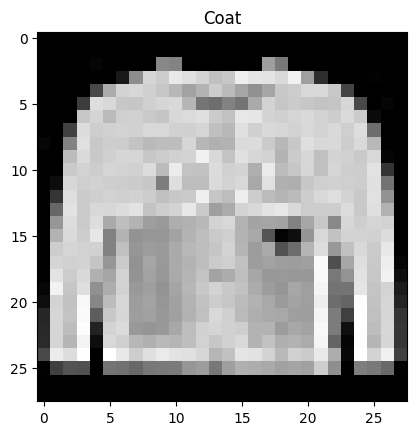

In [81]:
# Show a sample from dataloader

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
print(f"Image shape: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Building a Convolutional Neural Network (CNN)
**** 

CNN's are known for their capabilities to find patterns in visual data and since we are dealing with visual data, let's see if using CNN model gives us a promising result. 

The CNN model we're going to be using is know as TinyVGG from the `CNN Explainer` website. It follows the typical structure of a convolutional neural network. 

`Input Layer -> [Convolutional Layer -> Activation Layer -> Pooling layer] -> Output layer`

In [21]:
# Create a convolutional model
class FashionMNISTModel_check(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        print(f"shape after going through 1st block: {x.shape}")
        x = self.block_2(x)
        print(f"Shape after going through block 2: {x.shape} ")
        x = self.classifier(x)
        print(f"Shape after going through classifier: {x.shape}")



In [22]:
model_1 = FashionMNISTModel_check(input_shape=1,
                                  hidden_units=10,
                                  output_shape=len(class_names)).to(device)

In [23]:
img.shape

torch.Size([1, 28, 28])

In [24]:
random_tensor = torch.randn(size = (1,28,28))
random_tensor

tensor([[[ 4.7712e-01, -3.4099e-01,  1.8776e-01,  8.9365e-01,  6.7562e-01,
           8.5060e-01,  1.0084e+00, -5.3352e-01, -3.5988e-01, -7.9299e-01,
           2.8649e-01, -1.1414e-03,  2.0459e-01, -1.0171e+00,  4.9028e-01,
           3.6331e-01,  8.5475e-02, -3.6075e-01,  1.2428e+00,  9.5985e-01,
           2.2815e+00,  3.0750e-01, -1.6656e-01,  9.7245e-01, -1.6376e+00,
           1.2780e+00,  3.7403e-01, -3.3245e-01],
         [ 1.8481e-01, -1.8635e-01,  1.1403e+00, -4.8276e-01,  5.6579e-02,
           1.6874e+00, -1.7577e-01, -3.0367e-01, -6.8840e-01,  4.9279e-01,
          -9.2649e-01, -1.4322e-01, -3.3367e-03,  9.5760e-01, -9.8171e-01,
          -3.3166e-01,  8.1470e-01,  9.3321e-01,  1.7016e+00,  1.3845e+00,
           1.9308e-01, -1.3417e-01,  1.8064e+00,  2.3039e+00, -8.7742e-01,
           4.6085e-01, -9.0307e-01, -9.6555e-01],
         [-3.2243e-01,  3.7675e-01,  8.5621e-01, -9.9698e-01,  9.7812e-02,
           1.4651e-01, -1.1873e+00,  7.5588e-01,  6.0576e-01, -4.7643e-01,


In [26]:
random_tensor.shape

torch.Size([1, 28, 28])

In [27]:
model_1(random_tensor.to(device))

shape after going through 1st block: torch.Size([10, 14, 14])
Shape after going through block 2: torch.Size([10, 7, 7]) 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model_1(random_tensor.to(device))                                                            │
│   2                                                                                              │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1736 in    │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1733 │   │   if self._compiled_call_impl is not None:                                          │
│   1734 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1735 │   │   else:                                                                             │
│ ❱ 1736 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1737 │                                                                                         │
│   1738 │   # torchrec tests the code consistency with the following code                         │
│   1739 │   # fmt: off                                                                            │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1747 in    │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1744 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1745 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1746 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1747 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1748 │   │                                                                                     │
│   1749 │   │   result = None                                                                     │
│   1750 │   │   called_always_called_hooks = set()                                                │
│                                                                                                  │
│ in forward:47                                                                                    │
│                                                                                                  │
│   44 │   │   print(f"shape after going through 1st block: {x.shape}")                            │
│   45 │   │   x = self.block_2(x)                                                                 │
│   46 │   │   print(f"Shape after going through block 2: {x.shape} ")                             │
│ ❱ 47 │   │   x = self.classifier(x)                                                              │
│   48 │   │   print(f"Shape after going through classifier: {x.shape}")                           │
│   49                                                                                             │
│   50                                                                                             │
│                                                                                                  │
│ /opt/anaconda3/envs/python_ds/lib/python3.10/site-packages/torch/nn/modules/module.py:1736 in    │
│ _wrapped_call_impl                                         

In [82]:
# Create a convolutional model
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f"shape after going through 1st block: {x.shape}")
        x = self.block_2(x)
        # print(f"Shape after going through block 2: {x.shape} ")
        x = self.classifier(x)
        # print(f"Shape after going through classifier: {x.shape}")
        return x



In [83]:
model_1 = FashionMNISTModel(input_shape=1,
                            hidden_units=10,
                            output_shape=len(class_names)).to(device)


In [84]:
random_tensor.shape

torch.Size([1, 28, 28])

In [85]:
random_tensor.shape, random_tensor.unsqueeze(dim=0).shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [86]:
random_tensor = random_tensor.to(device)

In [87]:
model_1(random_tensor.unsqueeze(dim=0)) # output is logits. 

tensor([[ 0.0603, -0.0156,  0.0102, -0.0373,  0.0834,  0.0882, -0.0348,  0.0183,
         -0.0349, -0.0785]], grad_fn=<AddmmBackward0>)

## 3.1 Setup a loss function and optimizer
****
We are working with multi-class classification problem and that's why we will use `nn.CrossEntropyLoss()` and `torch.optim.SGD()` as the optimizer with learning rate of 0.1. 

In [88]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## 3.1 Getting helper functions
****

In [89]:
# get helper_funcions
import requests
from pathlib import Path

# Download helper functions from learn PyTorhch repo
if Path("helpr_functions.py").is_file():
    print("helper_function.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

## 3.3 Training and testing of model
****

In [90]:
device = "cpu"
device

'cpu'

In [91]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_loss, train_acc = 0,0
    model_1.to(device)
    for batch, (X, y) in enumerate(train_dataloader):
        ### Training
        # Send data to the device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model_1(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss 
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Printout what's happening
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}")

    ### Testing
    test_loss, test_acc = 0,0
    model_1.to(device)
    model_1.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model_1(X)

            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y) 
            test_acc += accuracy_fn(y_true = y,
                                    y_pred = test_pred.argmax(dim=1))
            
        # Print what's happening
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")
        


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 0.61173 | Train Accuracy: 77.79167


 33%|███▎      | 1/3 [01:46<03:32, 106.27s/it]

Test loss: 0.39402 | Test accuracy: 85.94249
Epoch: 1
-----------
Train loss: 0.34997 | Train Accuracy: 87.35000


 67%|██████▋   | 2/3 [03:19<01:38, 98.42s/it] 

Test loss: 0.32346 | Test accuracy: 88.77796
Epoch: 2
-----------
Train loss: 0.30691 | Train Accuracy: 88.95667


100%|██████████| 3/3 [04:59<00:00, 99.73s/it]

Test loss: 0.30386 | Test accuracy: 88.86781
